# **Import libraries**

In [206]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from numpy import where
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay,  roc_auc_score,roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, mean_squared_error,ConfusionMatrixDisplay,log_loss
from statistics import mean, stdev

# **Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Explore dataset**

In [261]:
dt = pd.read_csv('/content/diabetes prediction.csv')
dt.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [262]:
a = dt.drop(['Outcome'], axis=1)
b = dt['Outcome']
print(dt.shape)
print(a.shape)
print(b.shape)

(768, 9)
(768, 8)
(768,)


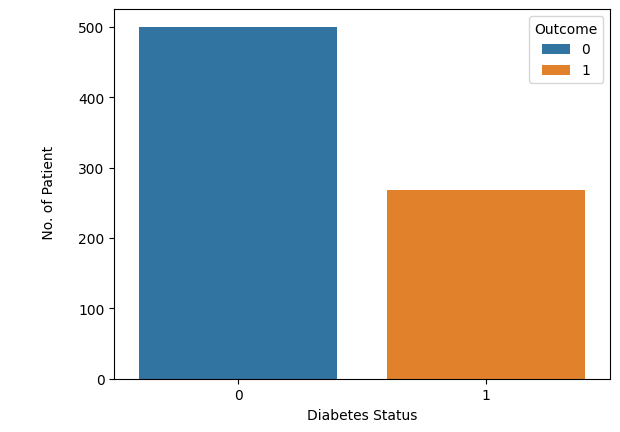

In [209]:
# Visualize counts of classes
gradebox = sns.countplot(x="Outcome",hue="Outcome", data=dt)
gradebox.set_xlabel('Diabetes Status')
gradebox.set_ylabel('\n \n No. of Patient\n')
fig = gradebox.get_figure()
fig.savefig('data.svg')
plt.show()

Counter({0: 500, 1: 268})


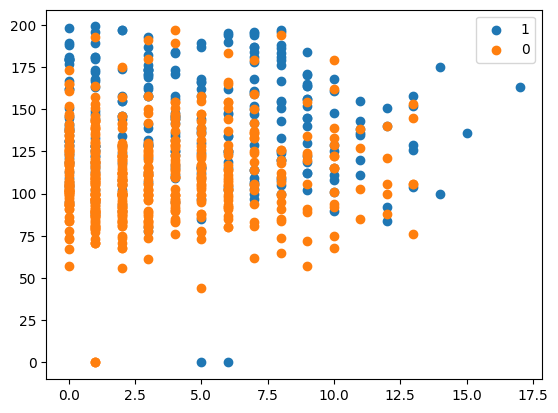

In [210]:
# summarize class distribution
counter = Counter(b)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(b == label)[0]
	plt.scatter(a.iloc[row_ix, 0], a.iloc[row_ix, 1], label=str(label))
plt.legend()
plt.show()

# **Normalize/standardize feature data**

In [211]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler , StandardScaler
#norm = MinMaxScaler()
norm = StandardScaler()
# transform training data
a_normalized = norm.fit_transform(a)
a_normalized = pd.DataFrame(a_normalized, columns=a.columns)
a_normalized.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


# **Model Traning, Optimization and Testing**



# **1. Random Forest**



In [101]:
# setting up testing and training sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(a, b, test_size= 0.10 , random_state= 101,stratify=b)

**It is ideal to use this normalization technique**

In [102]:
# fit scaler on training data
norm = StandardScaler().fit(X_train1)
# transform training data
X_train1 = norm.transform(X_train1)
# transform testing data
X_test1 = norm.transform(X_test1)

**Cross-validation and pipeline**

In [37]:
#StratifiedKFold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 101)
#model
model = RandomForestClassifier()
# make the pipeline
pipeline = make_pipeline(model)

**Hyperparameter optimization**

In [105]:
# define parameters
params = {
    'n_estimators': [10,15,17,25],
    'max_depth' : [1,2,3,4,5,6,7,8,9,11,12],
    'min_samples_leaf':[3,5,9,10],
    'criterion' :['gini']
}

new_params = {'randomforestclassifier__' + key: params[key] for key in params}

#define grid_search
grid_search2 = GridSearchCV(pipeline, param_grid=new_params, cv=cv, scoring='roc_auc',
                        return_train_score=True)

grid_search2.fit(X_train1, y_train1)

# get the best performing model, fit on the whole training set
best_model = grid_search2.best_estimator_
cv_score = grid_search2.best_score_
print('Cross-Validation Score : %.2f'% cv_score)

Cross-Validation Score : 0.85


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [106]:
grid_search2.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__min_samples_leaf': 9,
 'randomforestclassifier__n_estimators': 25}

**Built the final model with best parameters**

In [135]:
rf = RandomForestClassifier(criterion='gini',max_depth = 4, min_samples_leaf=9, n_estimators=25)

# train the model using traning set
rf.fit(X_train1,y_train1)

#test the trained model on test set
y_test_pred = rf.predict(X_test1)

print('Test Accuracy: %.2f' % accuracy_score(y_test1, y_test_pred))
print('Test_Precision: %.2f' % precision_score(y_test1, y_test_pred))
print('Test_Recall: %.2f' % recall_score(y_test1, y_test_pred))

Test Accuracy: 0.75
Test_Precision: 0.83
Test_Recall: 0.37


**Result Analysis**

In [136]:
#confusion matrix
matrix = confusion_matrix(y_test1,y_test_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)

# classification report for precision, recall f1-score and accuracy
matrix1 = classification_report(y_test1,y_test_pred,labels=[1,0])
print('Classification report : \n',matrix1)

Confusion matrix : 
 [[10 17]
 [ 2 48]]
Classification report : 
               precision    recall  f1-score   support

           1       0.83      0.37      0.51        27
           0       0.74      0.96      0.83        50

    accuracy                           0.75        77
   macro avg       0.79      0.67      0.67        77
weighted avg       0.77      0.75      0.72        77



Text(0.5, 23.52222222222222, 'Predicted label')

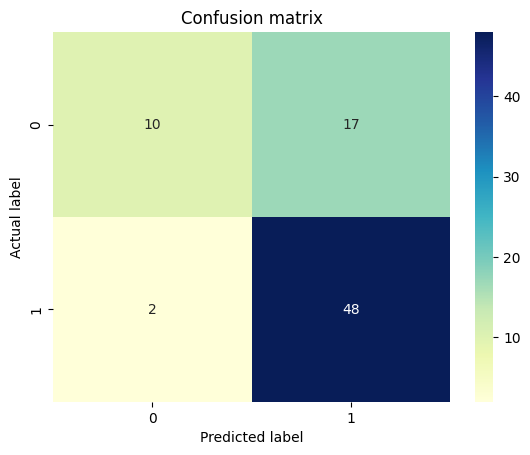

In [137]:
#plotting confusion matrix
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

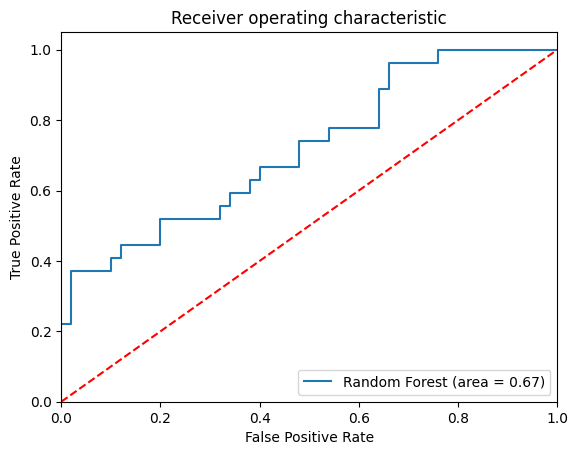

In [140]:
# calculating ROC_AUC score
rf_roc_auc = roc_auc_score(y_test1, rf.predict(X_test1))

# calulating the probability
y_pred_probability = rf.predict_proba((X_test1))

#plotting ROC_AUC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_probability[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



# **2. KNN**



In [201]:
# setting up testing and training sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(a, b, test_size= 0.10 , random_state= 101,stratify=b)

**It is ideal to use this normalization technique**

In [202]:
# fit scaler on training data
norm = StandardScaler().fit(X_train1)
# transform training data
X_train1 = norm.transform(X_train1)
# transform testing data
X_test1 = norm.transform(X_test1)

**Cross-validation**

In [204]:
#StratifiedKFold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 101)

**Hyperparamater optimization**

In [256]:
k_values = [i for i in range (1,19)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn,X_train1, y_train1,scoring= 'roc_auc', cv=cv)
    scores.append(np.mean(score))

best_index = np.argmax(scores)
best_k_value = k_values[best_index]
best_score = np.max(scores)
print('K =', (best_k_value))
print('Cross validation ROC_AUC : %.2f' % best_score)

K = 15
Cross validation ROC_AUC : 0.82


In [245]:
print('Cross validation ROC_AUC : %.2f' %(np.mean(score)))

Cross validation ROC_AUC : 0.82


**Built the final model with best parameters**

In [259]:
knn = KNeighborsClassifier(n_neighbors=15)

# train the model using traning set
knn.fit(X_train1,y_train1)

#test the trained model on test set
y_test_pred = knn.predict(X_test1)

print('Test Accuracy: %.2f' % accuracy_score(y_test1, y_test_pred))
print('Test_Precision: %.2f' % precision_score(y_test1, y_test_pred))
print('Test_Recall: %.2f' % recall_score(y_test1, y_test_pred))

Test Accuracy: 0.75
Test_Precision: 0.75
Test_Recall: 0.44


**Result Analysis**

In [260]:
#confusion matrix
matrix = confusion_matrix(y_test1,y_test_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)

# classification report for precision, recall f1-score and accuracy
matrix1 = classification_report(y_test1,y_test_pred,labels=[1,0])
print('Classification report : \n',matrix1)

Confusion matrix : 
 [[12 15]
 [ 4 46]]
Classification report : 
               precision    recall  f1-score   support

           1       0.75      0.44      0.56        27
           0       0.75      0.92      0.83        50

    accuracy                           0.75        77
   macro avg       0.75      0.68      0.69        77
weighted avg       0.75      0.75      0.73        77

